In [1]:
#import libraries and packages
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import opendatasets as od
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

2024-02-16 16:19:18.371947: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
##Functions to help make data more easily readable

#format to not include scientific notation
pd.options.display.float_format = '{:,.6f}'.format

#sets seaborn default style
sns.set()

In [3]:
#download and read dataset
url = 'https://raw.githubusercontent.com/ASaridena27/CardiovascularDiseaseDLProject/main/cardio_train%202.csv'
download = requests.get(url).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=';')

df['age'] = round(df['age'] / 365.25, 2)
df['years'] = df['age'].astype(int)  # Create 'years' column
df.insert(3, "female", (df['gender'] == 1).astype(int))
df.insert(4, 'male', (df['gender'] == 2).astype(int))
df.drop(['gender', 'id'], axis=1, inplace=True)
df.insert(5, 'bmi', round((df['weight'] / (df['height'] / 100) ** 2), 2))

In [4]:
df.head()

,age,female,male,height,weight,bmi,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,years
0,50.360000,0,1,168,62.000000,21.970000,110,80,1,1,0,0,1,0,50
1,55.380000,1,0,156,85.000000,34.930000,140,90,3,1,0,0,1,1,55
2,51.630000,1,0,165,64.000000,23.510000,130,70,3,1,0,0,0,1,51
3,48.250000,0,1,169,82.000000,28.710000,150,100,1,1,0,0,1,1,48
4,47.840000,1,0,156,56.000000,23.010000,100,60,1,1,0,0,0,0,47


In [5]:
##print rows and columns
print(f"Number of columns: { df.shape[1] }")
print(f"Number of rows: { df.shape[0] }")

df.info()

Number of columns: 15
Number of rows: 70000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  float64
 1   female       70000 non-null  int64  
 2   male         70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   bmi          70000 non-null  float64
 6   ap_hi        70000 non-null  int64  
 7   ap_lo        70000 non-null  int64  
 8   cholesterol  70000 non-null  int64  
 9   gluc         70000 non-null  int64  
 10  smoke        70000 non-null  int64  
 11  alco         70000 non-null  int64  
 12  active       70000 non-null  int64  
 13  cardio       70000 non-null  int64  
 14  years        70000 non-null  int64  
dtypes: float64(3), int64(12)
memory usage: 8.0 MB


In [6]:
df.describe()

,age,female,male,height,weight,bmi,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,years
count,"70,000.000000","70,000.000000","70,000.000000","70,000.000000","70,000.000000","70,000.000000","70,000.000000","70,000.000000","70,000.000000","70,000.000000","70,000.000000","70,000.000000","70,000.000000","70,000.000000","70,000.000000"
mean,53.302869,0.650429,0.349571,164.359229,74.205690,27.556545,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,52.807329
std,6.754974,0.476838,0.476838,8.210126,14.395757,6.091405,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.762506
min,29.560000,0.000000,0.000000,55.000000,10.000000,3.470000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.000000
25%,48.360000,0.000000,0.000000,159.000000,65.000000,23.880000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.000000
50%,53.940000,1.000000,0.000000,165.000000,72.000000,26.375000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,53.000000
75%,58.390000,1.000000,1.000000,170.000000,82.000000,30.220000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.000000
max,64.920000,1.000000,1.000000,250.000000,200.000000,298.670000,"16,020.000000","11,000.000000",3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.000000


In [7]:
df.drop(df.query('bmi >60 or bmi <15').index, axis=0, inplace=True)

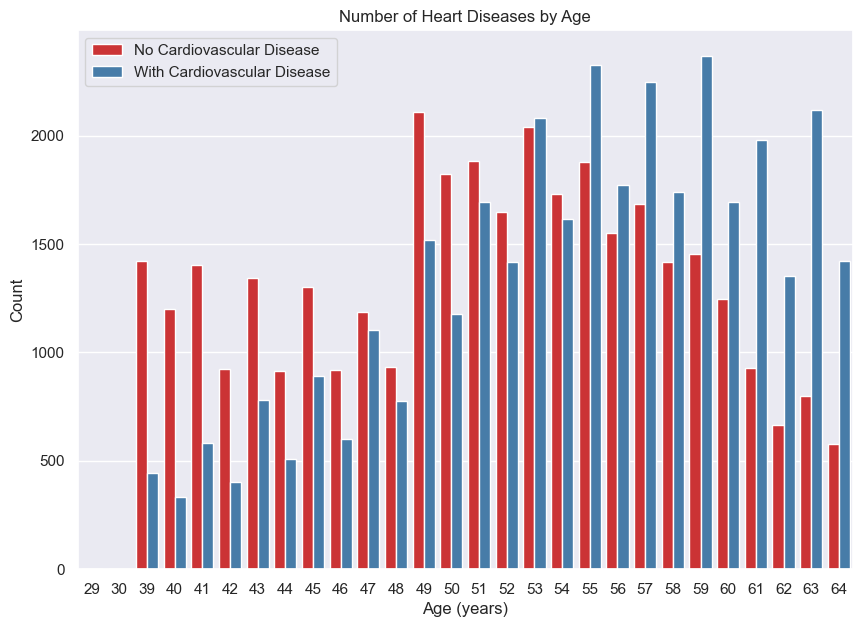

In [8]:
# The following section of code (Plot countplot)
# was retrieved on March 27, 2023, from
# EDA cardiovascular data by Svetlana Ulianova at
# kaggle.com/code/sulianova/eda-cardiovascular-data/notebook
# This is an adaption

# Plot countplot
plt.figure(figsize=(10, 7))
sns.countplot(x='years', hue='cardio', data=df, palette="Set1")
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.title('Number of Heart Diseases by Age')
plt.legend(["No Cardiovascular Disease", "With Cardiovascular Disease"])
plt.show()

In [9]:
# Count the number of individuals with and without cardiovascular disease by age
age_counts = df.groupby(["age", "cardio"]).size().unstack()

In [10]:
# Split the dataset into training and validation sets
train_ratio = 0.7
train_size = int(train_ratio * df.shape[0])
df_train = df.sample(n=train_size, random_state=0)
df_valid = df.drop(df_train.index)

# Normalize the features
max_val = df_train.max()
min_val = df_train.min()
df_train = (df_train - min_val) / (max_val - min_val)
df_valid = (df_valid - min_val) / (max_val - min_val)

# Split the features and target variable
train_X = df_train.drop('cardio', axis=1)
train_y = df_train['cardio']
val_X = df_valid.drop('cardio', axis=1)
val_y = df_valid['cardio']

In [11]:
# Deep learning model
model = keras.Sequential([
    layers.Dense(units=100, activation='relu', input_shape=[train_X.shape[1]]),
    layers.Dropout(rate=0.2),
    layers.Dense(units=100, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(patience=20, restore_best_weights=True)

# Train the model
history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    batch_size=64,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
_, accuracy = model.evaluate(val_X, val_y, verbose=0)
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))

Epoch 1/1000
765/765 [==============================] - 2s 2ms/step - loss: 0.6431 - accuracy: 0.6269 - val_loss: 0.6353 - val_accuracy: 0.6412
Epoch 2/1000
765/765 [==============================] - 1s 2ms/step - loss: 0.6321 - accuracy: 0.6413 - val_loss: 0.6307 - val_accuracy: 0.6361
Epoch 3/1000
765/765 [==============================] - 2s 2ms/step - loss: 0.6300 - accuracy: 0.6442 - val_loss: 0.6285 - val_accuracy: 0.6417
Epoch 4/1000
765/765 [==============================] - 1s 2ms/step - loss: 0.6284 - accuracy: 0.6457 - val_loss: 0.6274 - val_accuracy: 0.6433
Epoch 5/1000
765/765 [==============================] - 1s 2ms/step - loss: 0.6269 - accuracy: 0.6479 - val_loss: 0.6278 - val_accuracy: 0.6466
Epoch 6/1000
765/765 [==============================] - 1s 2ms/step - loss: 0.6268 - accuracy: 0.6497 - val_loss: 0.6267 - val_accuracy: 0.6451
Epoch 7/1000
765/765 [==============================] - 2s 2ms/step - loss: 0.6262 - accuracy: 0.6502 - val_loss: 0.6277 - val_accuracy:

765/765 [==============================] - 1s 2ms/step - loss: 0.5731 - accuracy: 0.7057 - val_loss: 0.5673 - val_accuracy: 0.7198
Epoch 58/1000
765/765 [==============================] - 2s 2ms/step - loss: 0.5727 - accuracy: 0.7076 - val_loss: 0.5686 - val_accuracy: 0.7184
Epoch 59/1000
765/765 [==============================] - 1s 2ms/step - loss: 0.5773 - accuracy: 0.7004 - val_loss: 0.5691 - val_accuracy: 0.7153
Epoch 60/1000
765/765 [==============================] - 1s 2ms/step - loss: 0.5766 - accuracy: 0.7016 - val_loss: 0.5787 - val_accuracy: 0.7087
Epoch 61/1000
765/765 [==============================] - 1s 2ms/step - loss: 0.5715 - accuracy: 0.7074 - val_loss: 0.5676 - val_accuracy: 0.7168
Epoch 62/1000
765/765 [==============================] - 1s 2ms/step - loss: 0.5746 - accuracy: 0.7043 - val_loss: 0.5794 - val_accuracy: 0.7052
Epoch 63/1000
765/765 [==============================] - 2s 2ms/step - loss: 0.5711 - accuracy: 0.7088 - val_loss: 0.5666 - val_accuracy: 0.7199

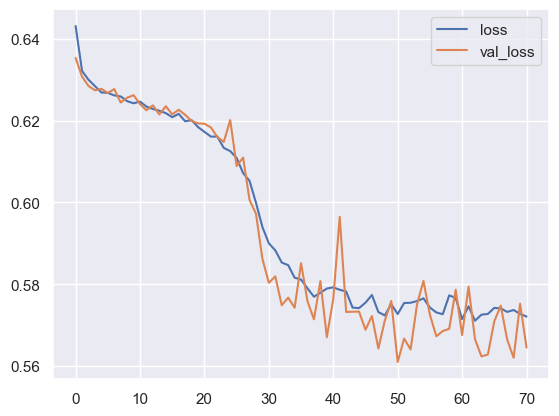

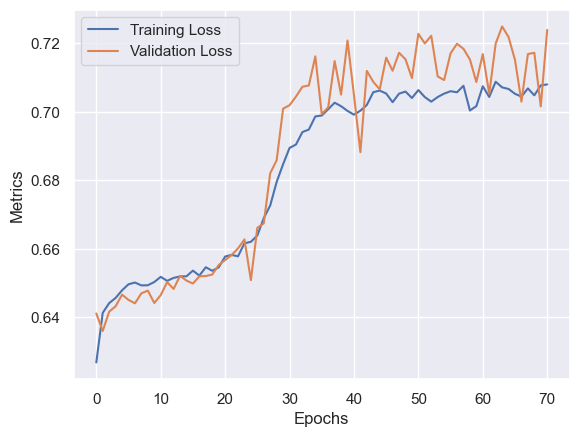

In [12]:
# Visualize training history
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend(['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])
plt.show()

In [13]:
# Print the best validation loss and accuracy
best_val_loss = history_df['val_loss'].min()
best_val_accuracy = history_df['val_accuracy'].max()
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

Best Validation Loss: 0.5610
Best Validation Accuracy: 0.7249


In [14]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Predict on the validation set
val_pred = model.predict(val_X)
val_pred_classes = (val_pred > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(val_y, val_pred_classes)
print("Confusion Matrix:")
print(cm)

656/656 [==============================] - 1s 844us/step
Confusion Matrix:
[[7632 2829]
 [2986 7526]]
